In [13]:
'''Examination of the variance in the likelihood estimate of the particle filter for varying number of particles N with the Toy example 
in section 16.5.1 on Introduction to SMC By Chopin and Papaspiliopoulos.'''
import sys
sys.path.append('../')

import numpy as np
import numba as nb
import matplotlib.pyplot as plt

from particle_filter import particlefilter
from pmcmc import particlemcmc
from scipy.stats import norm

In [14]:
'''AR Implementations'''
def AR_model(particles,observations,t,dt,model_params,rng):
    particles[:,0,t] = model_params[0] * particles[:,0,t] + rng.normal(size = (particles.shape[0],),scale = model_params[1]) 
    observations[:,0,t] = particles[:,0,t]

    return particles, observations   

def AR_Obs(data_point, particle_observations, model_params):
    return 1/np.sqrt(2 * np.pi * model_params[2]**2) * np.exp(-((data_point - particle_observations[:,0])**2)/(2 * model_params[2] ** 2))


In [15]:
rng = np.random.default_rng(0)

# '''Model'''

model_params = {'rho':0.9,'sigma_x':0.5,'sigma_y':1.2}

T = 300

X = np.zeros((T,))
X[0] = 0. 

Y = np.zeros((1,T))
Y[:,0] = 0. 

for t in range(1,T): 
    X[t] = model_params['rho'] * X[t-1] + rng.normal(0,model_params['sigma_x'])
    Y[:,t] = X[t] + rng.normal(0,model_params['sigma_y'])


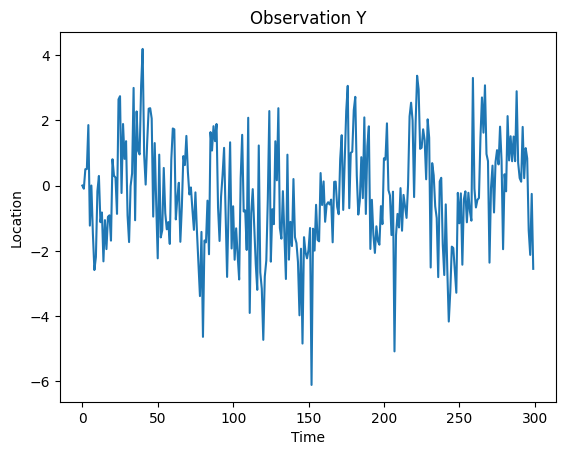

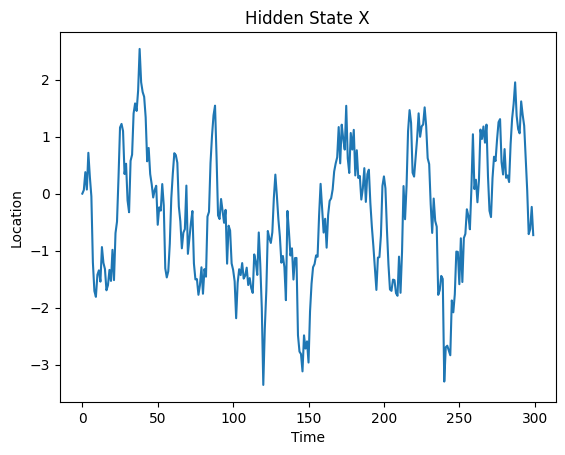

In [16]:
plt.title("Observation Y")
plt.ylabel('Location')
plt.xlabel('Time')
plt.plot(Y.T)
plt.show()

plt.title("Hidden State X")
plt.ylabel('Location')
plt.xlabel('Time')
plt.plot(X)
plt.show()

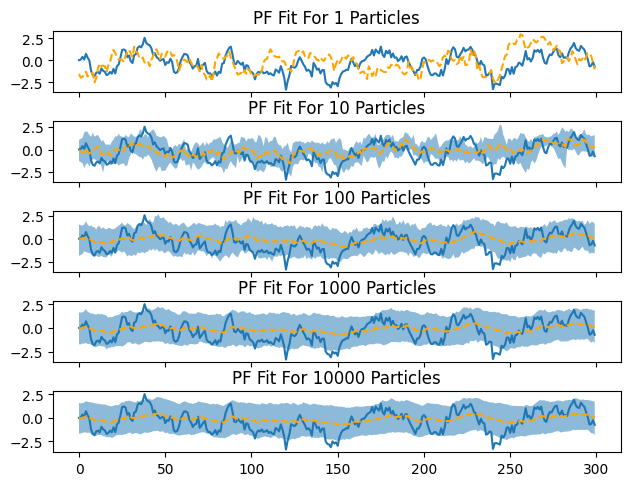

In [17]:


def AR_init(num_particles, model_dim, rng):
    particles_0 = np.zeros((num_particles,model_dim))
    particles_0[:,0] = rng.normal(0,1,size = (num_particles,))

    return particles_0
    

fig, ax = plt.subplots(5, 1, sharex=True)
fig.tight_layout()

num_particles_list = [1,10,100,1000,10_000]

for i,num_particles in enumerate(num_particles_list):

    pf_params = {'num_particles':num_particles, 
                'dt':1.,
                'model':AR_model,
                'observation_model':AR_Obs,
                'model_dim':1,
                'particle_initializer':AR_init,
                }

    output = particlefilter(data = Y,
    model_params= (model_params['rho'],model_params['sigma_x'],model_params['sigma_y']),
    pf_params = pf_params,
    rng = rng,
    req_jit=False
    )

    ax[i].set_title(f"PF Fit For {num_particles} Particles")
    ax[i].plot(X)
    ax[i].plot(np.arange(0,Y.shape[1]),np.average(output['particle_distribution'][:,0,:],weights = np.exp(output['log_weights']),axis = 0),'--',color = 'orange',zorder = 12)
    ax[i].fill_between(np.arange(0,Y.shape[1]),np.percentile(output['particle_distribution'][:,0,:],5,axis = 0),np.percentile(output['particle_distribution'][:,0,:],95,axis = 0),alpha = 0.5)

### <center> Likelihood Computation Using the Kalman Filter

The Hidden Markov Model is defined as follows. A latent process is given where $A \in \mathbb{R}^{p \times k}$ and $F \in \mathbb{R}^{k \times k}$ and 
$v_t,w_t$ are vectors of parameterized Gaussian noise. 

$$
y_t = Ax_t + v_t \\
x_t = Fx_{t-1} + w_t \\
w_t \sim \mathcal{N}(0,W)\\
v_t \sim \mathcal{N}(0,V)


$$

Formally, the Likelihood for a Hidden Markov Model is the unnormalized joint density $p(y_1,\dots,y_T)$ for some time series of observations of a latent process indexed by $1,2,\dots,T$. We can factorize as follows by the conditional independence assumptions of the Markov process. 

$$
p(y_1)\prod_{i=2}^T p(y_i|y_{1:i-1})
$$

First we need to compute $p(y_1)$. We can do so by considering the joint density $p(y_1,x_1)$ and integrating with respect to $x_1$. 

$$
p(y_1,x_1) = p(y_1|x_1)p(x_1) \\
p(y_1) = \int p(y_1|x_1)p(x_1) dx_1
$$

Note that $p(y_1|x_1)$ is the observation density, and $p(x_1)$ is the posterior density the latent state. 

Thus we can write $p(y_1|x_1) = \mathcal{N}(Ax_0^{forecast},V)$ and $\mathcal{N}(Fx_0^{forecast},FP_{0}^{forecast}F^T + W)$ where superscript denotes the posterior estimate and $P$ is the running covariance in the Kalman Filter.

$$
\int \mathcal{N}(Ax_0^{forecast},V) \mathcal{N}(Fx_0^{forecast},FP_{0}^{forecast}F^T + W) dx_0 \\
= \mathcal{N}(Ax_0^{forecast},AP_{0}^{forecast}A^T + V)
$$

In general we require densities of the form $p(y_i|y_{1:i-1})$ which can be factorized as follows. 

$$
p(y_i|y_{1:i-1}) = \int p(y_i,x_i|y_{1:i-1}) dx_i \\
= \int p(y_i|x_i)p(x_i|y_{1:i-1})dx_i \\
=\mathcal{N}(Ax_{i-1}^{forecast},AP_{i-1}^{forecast}A^T + V)
$$

Thus the full log likelihood takes the form 

$$
\mathcal{L}(\theta) = \sum\limits_{i=1}^T \log p(y_i|y_{1:i-1})
$$

/var/folders/3q/t1wxfpx9531dbcdd2380p6dm0000gp/T/ipykernel_22701/2987662622.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  LL[time_index] = norm.logpdf(x = Y[:,time_index], loc = posterior_mean[time_index],scale = np.sqrt(posterior_cov[time_index] + model_params['sigma_y']**2))
/var/folders/3q/t1wxfpx9531dbcdd2380p6dm0000gp/T/ipykernel_22701/2987662622.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior_mean[time_index] = posterior_mean[time_index] + K * (Y[:,time_index] - posterior_mean[time_index])


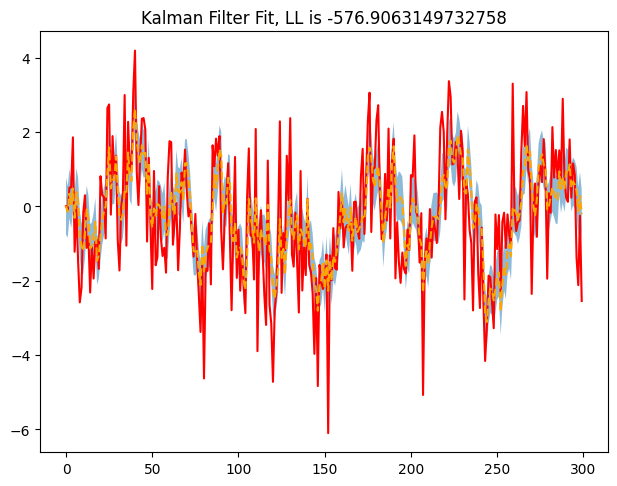

In [18]:
'''Implementation of the Kalman Filter'''

posterior_mean = np.zeros(T)
posterior_cov = np.zeros(T)

posterior_mean[0] = 0.
posterior_cov[0] = 1.

LL = np.zeros(T)

for time_index in range(T):

    '''Forecast'''
    if(time_index > 0):
        posterior_mean[time_index] = model_params['rho'] * posterior_mean[time_index-1] + rng.normal(0,model_params['sigma_x'])
        posterior_cov[time_index] = model_params['rho'] * posterior_cov[time_index-1] * model_params['rho'] + model_params['sigma_x']**2

    '''Likelihood'''
    LL[time_index] = norm.logpdf(x = Y[:,time_index], loc = posterior_mean[time_index],scale = np.sqrt(posterior_cov[time_index] + model_params['sigma_y']**2))

    '''Update'''
    K = posterior_cov[time_index] / (posterior_cov[time_index] + model_params['sigma_y']**2)

    posterior_mean[time_index] = posterior_mean[time_index] + K * (Y[:,time_index] - posterior_mean[time_index])
    posterior_cov[time_index] = (1 - K) * posterior_cov[time_index]

fig, ax = plt.subplots(1, sharex=True)
fig.tight_layout()  
ax.set_title(f'Kalman Filter Fit, LL is {np.sum(LL)}')
ax.plot(Y.T,color = 'red')
ax.plot(posterior_mean,'--',color = 'orange',zorder = 12)
ax.fill_between(np.arange(0,T), posterior_mean - np.sqrt(posterior_cov),posterior_mean + np.sqrt(posterior_cov),alpha = 0.5)

In [19]:
'''Running PMMH to estimate the model parameters'''

@nb.njit
def uniform_numba_logpdf(theta,min_val,max_val):
    return np.log(1/(max_val - min_val))

@nb.njit
def prior(theta):
    return uniform_numba_logpdf(theta[0],-1,1) + uniform_numba_logpdf(theta[1],0,4) + uniform_numba_logpdf(theta[2],0,4)

theta, LL,_ = PMCMC(iterations=10_000,
                  num_particles=1000,
                  init_theta=np.array([rng.uniform(-1,1),rng.gamma(2,1/2),rng.gamma(2,1/2)]),
                  data = Y,
                  rng = rng,
                  dt = 1, 
                  prior = prior, 
                  model = AR_model,
                  observation = AR_Obs,
                  model_dim=1)


NameError: name 'PMCMC' is not defined

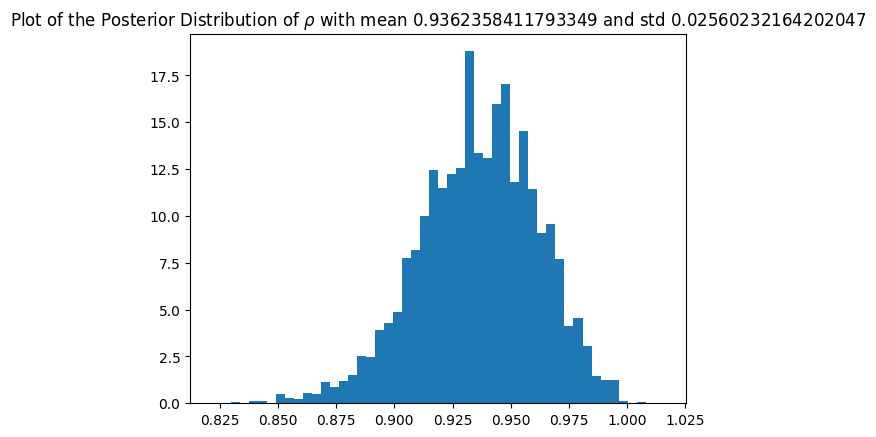

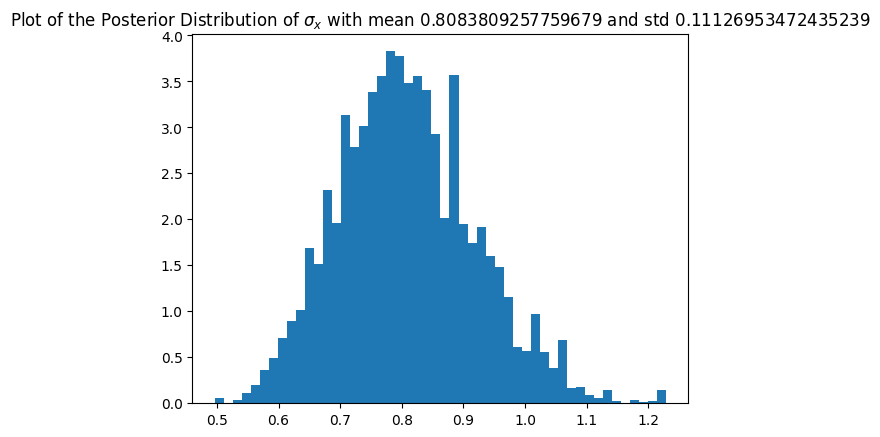

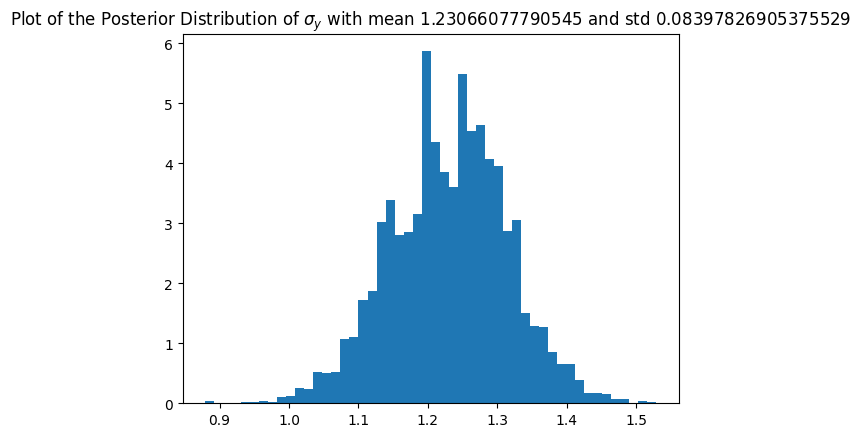

In [ ]:
burn_in = 1000
plt.title(f'Plot of the Posterior Distribution of $\\rho$ with mean {np.mean(theta[0,burn_in:])} and std {np.std(theta[0,burn_in:])}')
plt.hist(theta[0,burn_in:],density=True,bins = 50)
plt.show()

plt.title(f'Plot of the Posterior Distribution of $\\sigma_x$ with mean {np.mean(theta[1,burn_in:])} and std {np.std(theta[1,burn_in:])}')
plt.hist(theta[1,burn_in:],density=True,bins = 50)
plt.show()

plt.title(f'Plot of the Posterior Distribution of $\\sigma_y$ with mean {np.mean(theta[2,burn_in:])} and std {np.std(theta[2,burn_in:])}')
plt.hist(theta[2,burn_in:],density=True,bins = 50)
plt.show()

Text(0.5, 0, 'Iteration')

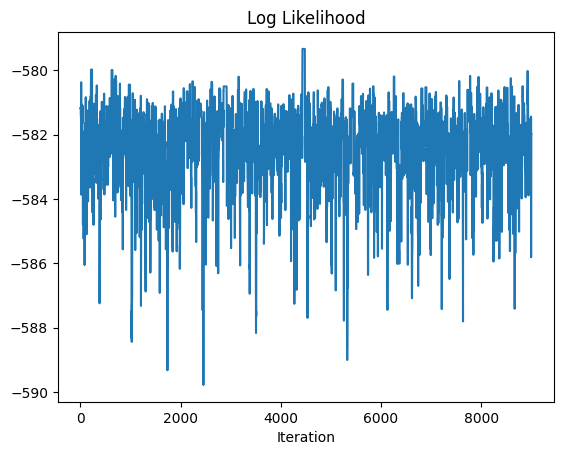

In [ ]:
plt.title('Log Likelihood')
plt.plot(LL[burn_in:])
plt.xlabel('Iteration')